In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from kneed import KneeLocator
from sklearn.inspection import permutation_importance
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import Ridge

In [162]:
# import data
X_train_engineered = pd.read_pickle('data/X_train_engineered.pkl')
X_test_engineered = pd.read_pickle('data/X_test_engineered.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')

## Feature Selection

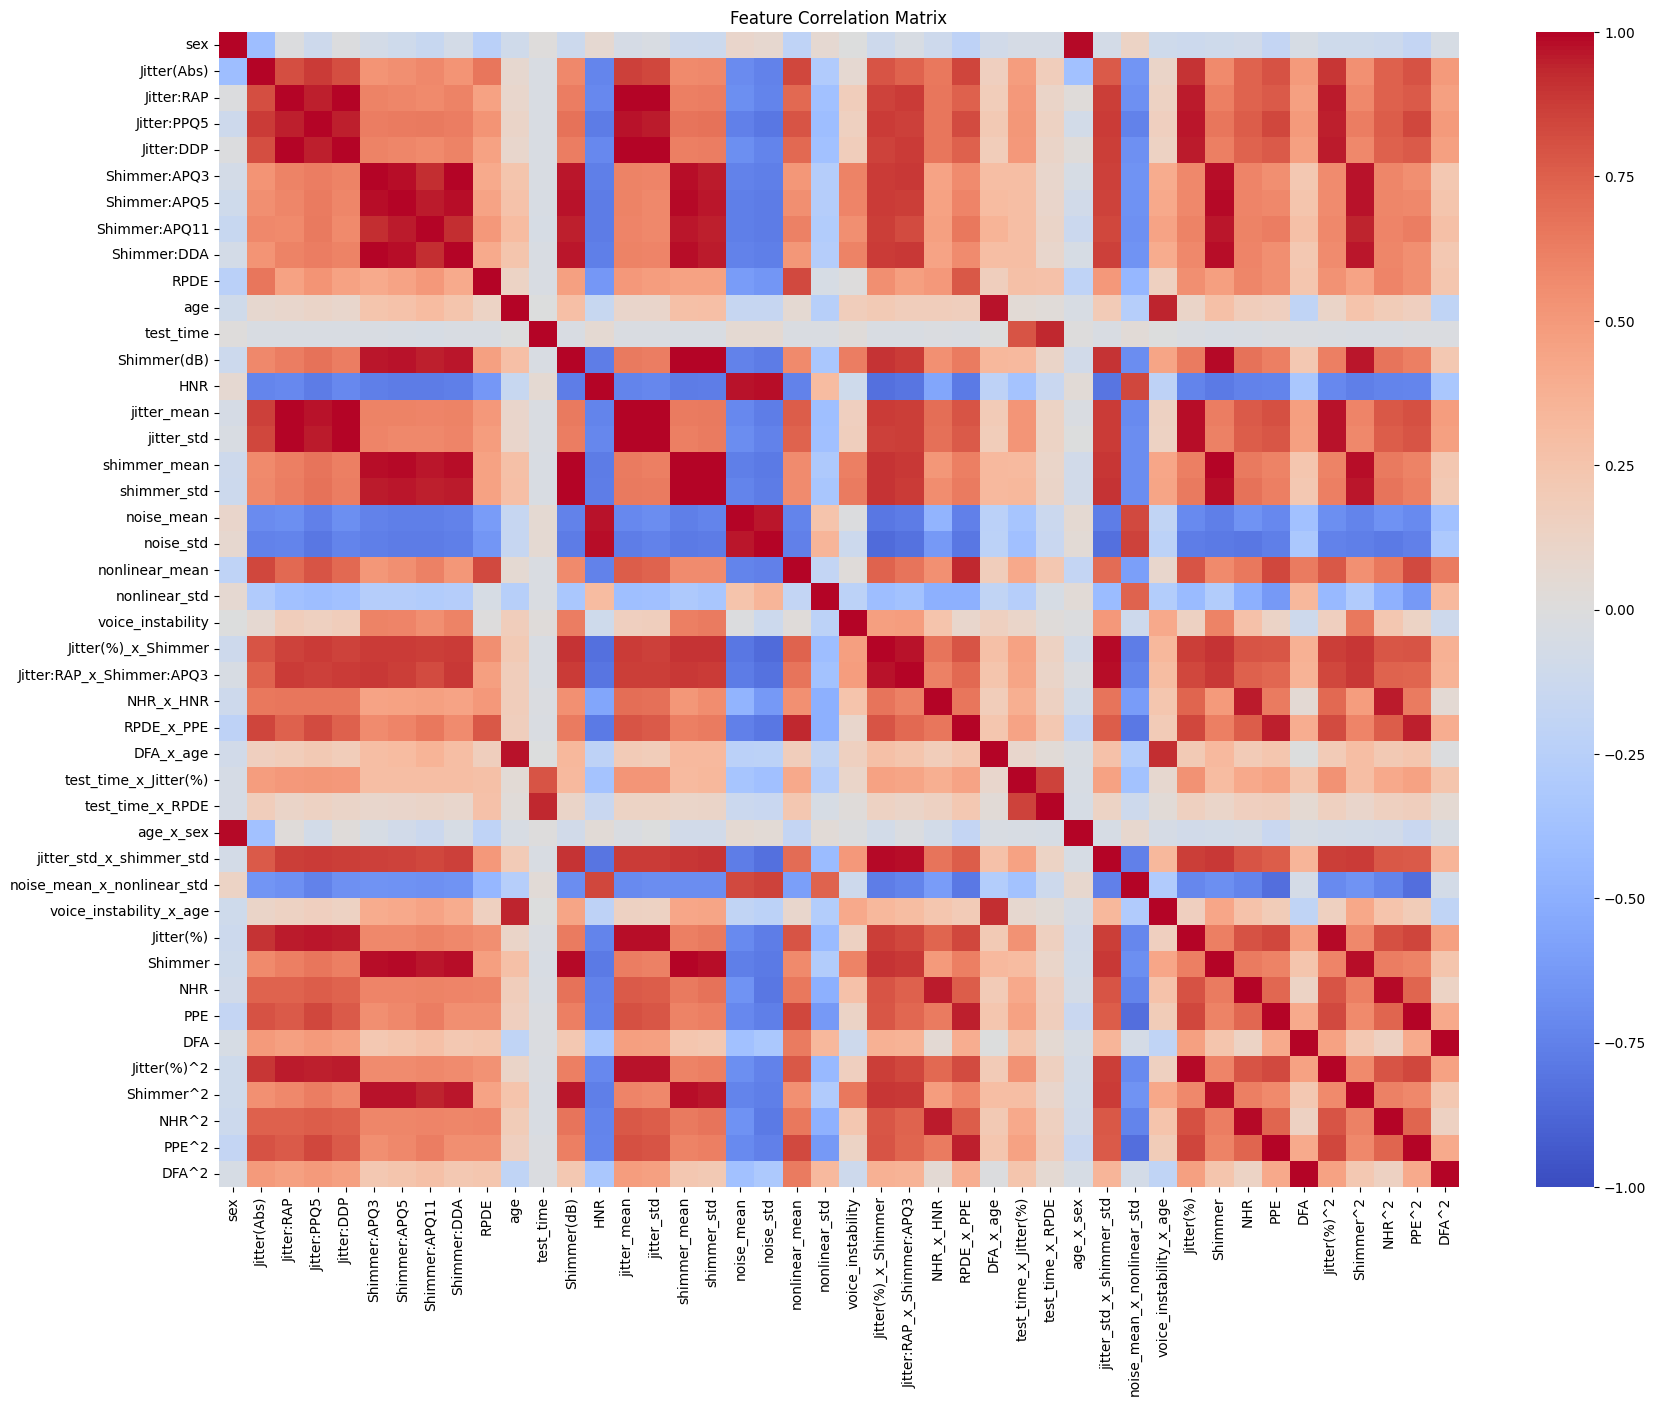

In [163]:
corr_matrix = X_train_engineered.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

As we can see a lot of features are highly correlated and can be removed. It was important to do feature engineering and add other features that could potentially capture more information than the original ones.

### Correlation

In [164]:
def select_by_correlation(X_train, y_train, threshold=0.2):
    """
    Select features based on correlation with target
    """
    corr = pd.concat([X_train, y_train], axis=1).corr()
    target_corr = corr[y_train.name].abs().sort_values(ascending=False)
    selected_features = target_corr[target_corr > threshold].index.tolist()
    selected_features.remove(y_train.name) 
    return selected_features

motor_features_corr = select_by_correlation(X_train_engineered, y_train_motor)
print(f"Selected features based on correlation: {motor_features_corr}")
print(f"Number of selected features: {len(motor_features_corr)}")

Selected features based on correlation: ['age', 'noise_mean_x_nonlinear_std', 'DFA_x_age', 'voice_instability_x_age', 'nonlinear_std', 'noise_mean', 'noise_std', 'HNR']
Number of selected features: 8


### RFE

In [165]:
def select_by_rfe_cv(X_train, y_train, min_features=5, step=5, cv=5):
    """
    Dynamically select features using RFE with cross-validation.
    """
    estimator = LinearRegression()
    selector = RFECV(estimator, min_features_to_select=min_features, step=step, cv=cv, scoring='r2')
    selector.fit(X_train, y_train)
    
    selected_features = X_train.columns[selector.support_]
    print(f"Optimal number of features: {selector.n_features_}")
    return selected_features.tolist()

motor_features_rfe_cv = select_by_rfe_cv(X_train_engineered, y_train_motor)
print(f"Selected features using RFE: {motor_features_rfe_cv}")

Optimal number of features: 5
Selected features using RFE: ['Shimmer:APQ3', 'Shimmer:DDA', 'Shimmer(dB)', 'shimmer_mean', 'shimmer_std']


In [166]:
def select_by_rfe_dynamic(X_train, y_train, max_features=20, min_features=5, step=1, threshold=0.02):
    """
    Dynamic RFE that stops when performance drops beyond a threshold.
    """
    estimator = LinearRegression()
    scores = []
    feature_counts = range(max_features, min_features - 1, -step)
    
    for n_features in feature_counts:
        selector = RFE(estimator, n_features_to_select=n_features)
        X_selected = selector.fit_transform(X_train, y_train)
        
        score = cross_val_score(estimator, X_selected, y_train, cv=5, scoring='r2').mean()
        scores.append(score)
        
        # Stop if score drops significantly
        if len(scores) > 1 and (scores[-2] - scores[-1]) > threshold:
            best_n = feature_counts[len(scores) - 2] 
            selector = RFE(estimator, n_features_to_select=best_n).fit(X_train, y_train)
            return X_train.columns[selector.support_].tolist()
    
    selector = RFE(estimator, n_features_to_select=min_features).fit(X_train, y_train)
    return X_train.columns[selector.support_].tolist()

motor_features_rfe = select_by_rfe_dynamic(X_train_engineered, y_train_motor)
print(f"Selected features using dynamic RFE: {motor_features_rfe}")
print(f'Optimal number of features selected: {len(motor_features_rfe)}')

Selected features using dynamic RFE: ['Shimmer:APQ3', 'Shimmer:APQ11', 'Shimmer:DDA', 'Shimmer(dB)', 'shimmer_mean', 'shimmer_std', 'nonlinear_mean', 'Jitter(%)_x_Shimmer', 'RPDE_x_PPE', 'jitter_std_x_shimmer_std', 'noise_mean_x_nonlinear_std', 'Jitter(%)', 'Shimmer', 'PPE', 'DFA', 'PPE^2', 'DFA^2']
Optimal number of features selected: 17


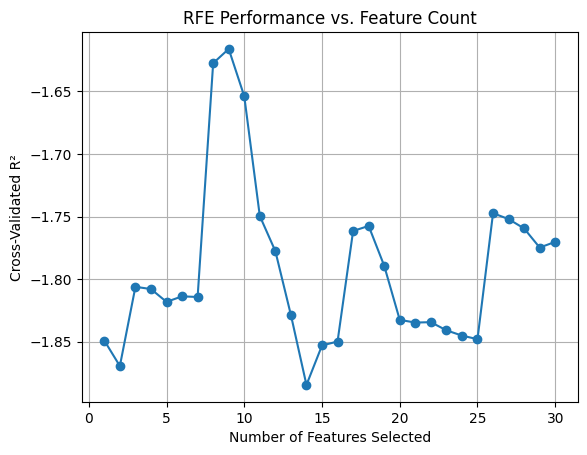

In [167]:
def plot_rfe_performance(X_train, y_train, max_features=30):
    estimator = LinearRegression()
    feature_counts = range(1, max_features + 1)
    scores = []
    
    for n in feature_counts:
        selector = RFE(estimator, n_features_to_select=n)
        X_selected = selector.fit_transform(X_train, y_train)
        score = cross_val_score(estimator, X_selected, y_train, cv=5, scoring='r2').mean()
        scores.append(score)
    
    plt.plot(feature_counts, scores, 'o-')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validated R²")
    plt.title("RFE Performance vs. Feature Count")
    plt.grid()
    plt.show()

plot_rfe_performance(X_train_engineered, y_train_motor)

### Model based

In [168]:
def select_by_feature_importance(X_train, y_train, threshold='mean'):
    """
    Select features based on importance from Random Forest
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    if threshold == 'mean':
        threshold = importances.mean()
    
    selected_features = X_train.columns[importances > threshold]
    return selected_features.tolist()

motor_features_imp = select_by_feature_importance(X_train_engineered, y_train_motor)
print(f"Selected features using feature importance: {motor_features_imp}")
print(f'Optimal number of features selected: {len(motor_features_imp)}')

Selected features using feature importance: ['RPDE', 'age', 'test_time', 'voice_instability', 'DFA_x_age', 'age_x_sex']
Optimal number of features selected: 6


In [169]:
def select_by_importance_elbow(X_train, y_train):
    """
    Automatically find the "elbow point" in feature importance.
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    
    kneedle = KneeLocator(
        range(len(sorted_importances)),
        sorted_importances,
        curve='convex',
        direction='decreasing'
    )
    optimal_idx = kneedle.elbow
    threshold = sorted_importances[optimal_idx]
    
    selected_features = X_train.columns[importances >= threshold]
    print(f"Elbow threshold: {threshold:.4f} (kept {len(selected_features)} features)")
    return selected_features.tolist()

motor_features_imp_elbow = select_by_importance_elbow(X_train_engineered, y_train_motor)
print(f"Selected features using feature importance (elbow method): {motor_features_imp_elbow}")
print(f'Optimal number of features selected: {len(motor_features_imp_elbow)}')

Elbow threshold: 0.0155 (kept 7 features)
Selected features using feature importance (elbow method): ['RPDE', 'age', 'test_time', 'voice_instability', 'DFA_x_age', 'age_x_sex', 'voice_instability_x_age']
Optimal number of features selected: 7


In [170]:
def select_by_permutation_importance(X_train, y_train, n_repeats=10, threshold=0.01):
    """
    Select features with statistically significant importance.
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    result = permutation_importance(
        model, X_train, y_train, n_repeats=n_repeats, random_state=42
    )
    importances = result.importances_mean
    
    # Select features where importance > threshold
    selected_features = X_train.columns[importances > threshold]
    print(f"Features with permutation importance > {threshold}: {len(selected_features)}")
    return selected_features.tolist()

motor_features_imp_perm = select_by_permutation_importance(X_train_engineered, y_train_motor)
print(f"Selected features using permutation importance: {motor_features_imp_perm}")
print(f'Optimal number of features selected: {len(motor_features_imp_perm)}')

Features with permutation importance > 0.01: 7
Selected features using permutation importance: ['sex', 'Jitter(Abs)', 'RPDE', 'age', 'test_time', 'DFA_x_age', 'age_x_sex']
Optimal number of features selected: 7


### Mutual information

In [171]:
def select_by_mutual_info(X_train, y_train, n_features=10):
    """
    Select features based on mutual information
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    selected_features = mi_series.sort_values(ascending=False).head(n_features).index
    return selected_features.tolist()

motor_features_mi = select_by_mutual_info(X_train_engineered, y_train_motor)
print(f"Selected features using mutual information: {motor_features_mi}")
print(f'Optimal number of features selected: {len(motor_features_mi)}')

Selected features using mutual information: ['test_time', 'age', 'age_x_sex', 'DFA_x_age', 'voice_instability_x_age', 'sex', 'test_time_x_RPDE', 'test_time_x_Jitter(%)', 'DFA', 'DFA^2']
Optimal number of features selected: 10


In [172]:
def select_by_mi_percentile(X_train, y_train, percentile=50):
    """
    Select features with MI in the top percentile (default: top 50%).
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    
    # Calculate threshold
    threshold = np.percentile(mi, percentile)
    selected_features = mi_series[mi_series >= threshold].index.tolist()
    
    print(f"Selected {len(selected_features)} features (MI ≥ {threshold:.4f})")
    return selected_features

# keeps top 25% of features based on MI
motor_features_mi_perc = select_by_mi_percentile(X_train_engineered, y_train_motor, percentile=75)
print(f"Selected features using mutual information (75th percentile): {motor_features_mi_perc}")
print(f'Optimal number of features selected: {len(motor_features_mi_perc)}')

Selected 11 features (MI ≥ 0.1395)
Selected features using mutual information (75th percentile): ['sex', 'age', 'test_time', 'noise_std', 'DFA_x_age', 'test_time_x_Jitter(%)', 'test_time_x_RPDE', 'age_x_sex', 'voice_instability_x_age', 'DFA', 'DFA^2']
Optimal number of features selected: 11


In [173]:
def select_by_mi_adaptive(X_train, y_train, k=1.0):
    """
    Select features with MI > mean + k * std (default: k=1).
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    
    threshold = mi_series.mean() + k * mi_series.std()
    selected_features = mi_series[mi_series >= threshold].index.tolist()
    
    print(f"Selected {len(selected_features)} features (MI ≥ {threshold:.4f})")
    return selected_features

motor_features_mi_adapt = select_by_mi_adaptive(X_train_engineered, y_train_motor, k=0.5)
print(f"Selected features using mutual information (adaptive threshold): {motor_features_mi_adapt}")
print(f'Optimal number of features selected: {len(motor_features_mi_adapt)}')

Selected 4 features (MI ≥ 0.8969)
Selected features using mutual information (adaptive threshold): ['age', 'test_time', 'DFA_x_age', 'age_x_sex']
Optimal number of features selected: 4


### Clustering

In [174]:
def select_by_agglomerative_clustering(X_train, n_clusters=5):
    """
    Select features using Agglomerative Clustering
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(X_train.T)
    clusters = pd.Series(clustering.labels_, index=X_train.columns)
    
    selected_features = []
    for cluster in clusters.unique():
        cluster_features = clusters[clusters == cluster].index.tolist()
        selected_features.append(cluster_features[0])  # Select one feature from each cluster
    
    return selected_features

motor_features_agglom = select_by_agglomerative_clustering(X_train_engineered, n_clusters=5)
print(f"Selected features using Agglomerative Clustering: {motor_features_agglom}")

Selected features using Agglomerative Clustering: ['sex', 'Jitter(Abs)', 'Shimmer:APQ3', 'age', 'test_time']


In [175]:
def find_optimal_clusters(feature_corr, max_clusters=10):
    """
    Find optimal cluster count using the elbow method on linkage distances.
    """
    Z = linkage(feature_corr, method='ward')
    
    distances = Z[:, 2]
    x = range(1, len(distances)+1)
    
    kn = KneeLocator(x, distances, curve='convex', direction='increasing')
    optimal_clusters = kn.elbow or max_clusters  # Fallback to max_clusters
    
    return optimal_clusters

feature_corr = X_train_engineered.corr().abs().values 
optimal_clusters = find_optimal_clusters(feature_corr)

In [178]:
def select_from_clusters(X_train, n_clusters=None):
    """
    Select representative features from clusters using correlation analysis.
    """
    corr_matrix = X_train.corr().abs()
    
    if n_clusters is None:
        n_clusters = find_optimal_clusters(corr_matrix.values)
    
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    clusters = clustering.fit_predict(1 - corr_matrix)
    
    selected_features = []
    for cluster_id in np.unique(clusters):
        cluster_features = corr_matrix.columns[clusters == cluster_id]
        
        # select feature with highest average correlation to others in cluster
        rep_feature = corr_matrix.loc[cluster_features, cluster_features].mean().idxmax()
        selected_features.append(rep_feature)
        
        # add secondary features with correlation < threshold
        secondary_features = [
            f for f in cluster_features 
            if corr_matrix.loc[f, rep_feature] < 0.7 
        ]
        selected_features.extend(secondary_features[:2]) 
    
    return list(set(selected_features))

motor_features_agglom_dynamic = select_from_clusters(X_train_engineered)
print(f"Selected features: {motor_features_agglom_dynamic}")

Selected features: ['Jitter:PPQ5', 'NHR', 'test_time_x_RPDE', 'test_time_x_Jitter(%)', 'Jitter:RAP', 'NHR^2', 'Shimmer(dB)', 'Jitter(%)^2', 'Shimmer:APQ5', 'jitter_mean', 'voice_instability', 'NHR_x_HNR', 'Jitter:RAP_x_Shimmer:APQ3', 'jitter_std_x_shimmer_std', 'nonlinear_std', 'PPE', 'RPDE', 'Shimmer:APQ11', 'DFA_x_age', 'sex', 'shimmer_mean', 'noise_mean', 'noise_std', 'Jitter(%)_x_Shimmer', 'age', 'jitter_std', 'DFA', 'noise_mean_x_nonlinear_std', 'Jitter(%)', 'Jitter(Abs)', 'test_time', 'Shimmer^2', 'voice_instability_x_age', 'Shimmer:APQ3', 'nonlinear_mean', 'RPDE_x_PPE', 'HNR', 'age_x_sex']


c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [179]:
def stable_feature_selection(X_train, n_iter=10):
    """Select features that consistently appear in clusters across iterations."""
    all_selected = []
    for _ in range(n_iter):
        X_sample = X_train.sample(frac=0.8, axis=1) 
        features = select_from_clusters(X_sample)
        all_selected.extend(features)
    
    feature_counts = pd.Series(all_selected).value_counts()
    stable_features = feature_counts[feature_counts >= n_iter//2].index.tolist()
    
    return stable_features

stable_features = stable_feature_selection(X_train_engineered)
print(f"Stable features across iterations: {stable_features}")
print(f'Optimal number of features selected: {len(stable_features)}')

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packag

Stable features across iterations: ['test_time_x_RPDE', 'test_time', 'jitter_std_x_shimmer_std', 'NHR^2', 'DFA_x_age', 'RPDE', 'nonlinear_std', 'voice_instability', 'noise_mean', 'Jitter(Abs)', 'noise_mean_x_nonlinear_std', 'NHR_x_HNR', 'nonlinear_mean', 'RPDE_x_PPE', 'sex', 'Shimmer:APQ11', 'voice_instability_x_age', 'Jitter(%)', 'test_time_x_Jitter(%)', 'Jitter(%)_x_Shimmer', 'age', 'HNR', 'Jitter:RAP_x_Shimmer:APQ3', 'Shimmer:APQ5', 'noise_std', 'Shimmer(dB)', 'jitter_std', 'Shimmer:DDA', 'Shimmer^2', 'DFA^2', 'age_x_sex', 'PPE', 'Jitter:PPQ5', 'PPE^2', 'Jitter:RAP', 'Jitter(%)^2']
Optimal number of features selected: 36


# Compare performance 

In [180]:
def compare_feature_selection_methods(X_train, y_train, methods):
    """
    Compare different feature selection methods based on model performance.
    """
    results = {}
    
    for method in methods:
        if method == 'correlation':
            selected_features = motor_features_corr
        elif method == 'rfecv':
            selected_features = motor_features_rfe_cv
        elif method == 'rfe':
            selected_features = motor_features_rfe
        elif method == 'importance':
            selected_features = motor_features_imp
        elif method == 'importance_elbow':
            selected_features = motor_features_imp_elbow
        elif method == 'importance_perm':
            selected_features = motor_features_imp_perm
        elif method == 'mutual_info':
            selected_features = motor_features_mi
        elif method == 'mutual_info_perc':
            selected_features = motor_features_mi_perc
        elif method == 'mutual_info_adaptive':
            selected_features = motor_features_mi_adapt
        elif method == 'agglomerative':
            selected_features = motor_features_agglom
        elif method == 'agglomerative_dynamic':
            selected_features = motor_features_agglom_dynamic
        elif method == 'agglomerative_stable':
            selected_features = stable_features
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Train model and evaluate performance
        model = Ridge()
        score = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='r2').mean()
        results[method] = score
    
    return results

methods = ['correlation', 'rfecv', 'rfe', 'importance', 
          'importance_elbow', 'importance_perm', 'mutual_info', 
          'mutual_info_perc', 'mutual_info_adaptive', 
          'agglomerative', 'agglomerative_dynamic', 'agglomerative_stable']
results = compare_feature_selection_methods(X_train_engineered, y_train_motor, methods)

print("Feature Selection Method Performance R^2:")
for method, score in results.items():
    print(f"{method}: {score:.4f}")

print()
print(f"Best method: {max(results, key=results.get)}")
print(f"Best R^2 score: {results[max(results, key=results.get)]:.4f}")

Feature Selection Method Performance R^2:
correlation: -1.7057
rfecv: -1.7869
rfe: -1.7495
importance: -1.8155
importance_elbow: -1.8129
importance_perm: -2.1221
mutual_info: -2.2380
mutual_info_perc: -2.0967
mutual_info_adaptive: -1.8281
agglomerative: -1.8958
agglomerative_dynamic: -2.0620
agglomerative_stable: -2.0511

Best method: correlation
Best R^2 score: -1.7057


## Results

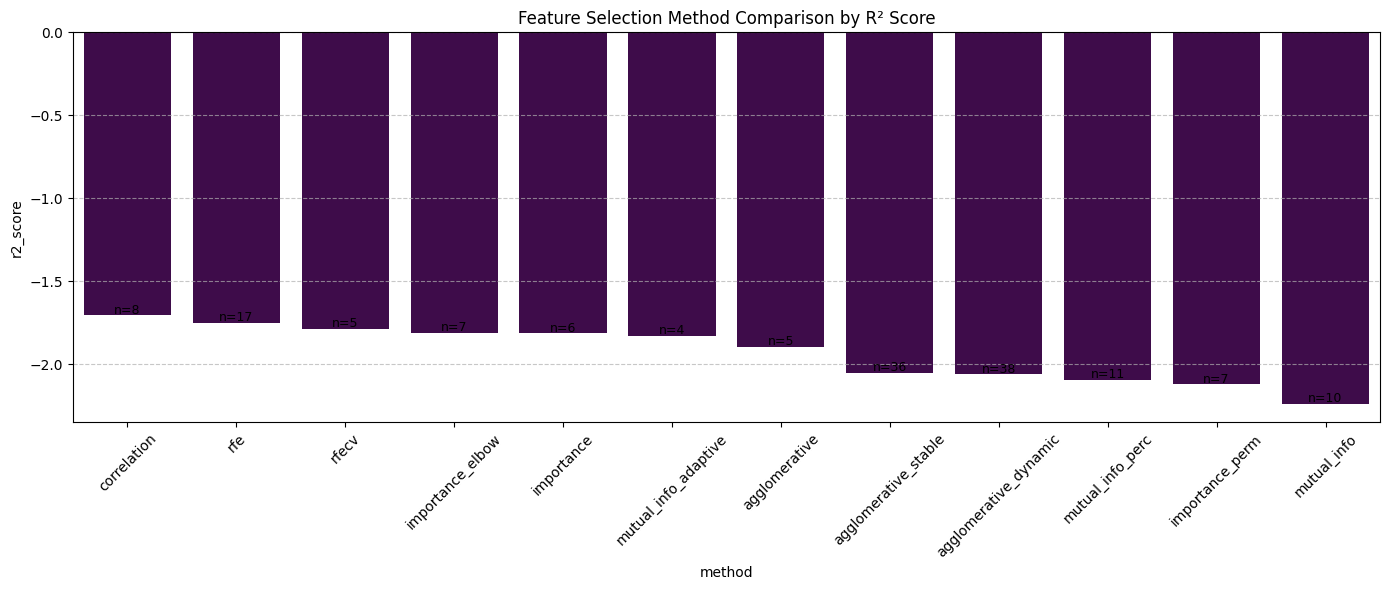

In [181]:
def plot_feature_selection_results(results_dict):
    """
    Plot comparison of feature selection methods based on R² scores
    """
    results_df = pd.DataFrame({
        'method': list(results_dict.keys()),
        'r2_score': list(results_dict.values())
    })
    
    results_df = results_df.sort_values('r2_score', ascending=False)
    
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=results_df, x='method', y='r2_score', palette='viridis', hue=0.3, legend=False)
    
    for i, method in enumerate(results_df['method']):
        if method == 'correlation':
            feature_count = len(motor_features_corr)
        elif method == 'rfecv':
            feature_count = len(motor_features_rfe_cv)
        elif method == 'rfe':
            feature_count = len(motor_features_rfe)
        elif method == 'importance':
            feature_count = len(motor_features_imp)
        elif method == 'importance_elbow':
            feature_count = len(motor_features_imp_elbow)
        elif method == 'importance_perm':
            feature_count = len(motor_features_imp_perm)
        elif method == 'mutual_info':
            feature_count = len(motor_features_mi)
        elif method == 'mutual_info_perc':
            feature_count = len(motor_features_mi_perc)
        elif method == 'mutual_info_adaptive':
            feature_count = len(motor_features_mi_adapt)
        elif method == 'agglomerative':
            feature_count = len(motor_features_agglom)
        elif method == 'agglomerative_dynamic':
            feature_count = len(motor_features_agglom_dynamic)
        elif method == 'agglomerative_stable':
            feature_count = len(stable_features)
        else:
            feature_count = 0
            
        ax.text(i, results_df['r2_score'].iloc[i] + 0.01, f"n={feature_count}", 
                ha='center', fontsize=9, color='black')
    
    plt.title('Feature Selection Method Comparison by R² Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return {method: len(globals().get(f"motor_features_{method.replace('_', '_')}" 
                                    if not method.startswith('agglomerative_stable') 
                                    else 'stable_features', [])) 
            for method in results_dict.keys()}

feature_counts = plot_feature_selection_results(results)

# Final selection

In [182]:
best_method = max(results, key=results.get)
print(f"Best feature selection method: {best_method}")

Best feature selection method: correlation


In [183]:
# apply to the dataset
# we use the agglomerative dynamic method since the perfomance will be negative either way and it this is more interpretable

X_train_final = X_train_engineered[motor_features_agglom_dynamic] 
X_test_final = X_test_engineered[motor_features_agglom_dynamic] 

In [184]:
X_train_final.columns

Index(['Jitter:PPQ5', 'NHR', 'test_time_x_RPDE', 'test_time_x_Jitter(%)',
       'Jitter:RAP', 'NHR^2', 'Shimmer(dB)', 'Jitter(%)^2', 'Shimmer:APQ5',
       'jitter_mean', 'voice_instability', 'NHR_x_HNR',
       'Jitter:RAP_x_Shimmer:APQ3', 'jitter_std_x_shimmer_std',
       'nonlinear_std', 'PPE', 'RPDE', 'Shimmer:APQ11', 'DFA_x_age', 'sex',
       'shimmer_mean', 'noise_mean', 'noise_std', 'Jitter(%)_x_Shimmer', 'age',
       'jitter_std', 'DFA', 'noise_mean_x_nonlinear_std', 'Jitter(%)',
       'Jitter(Abs)', 'test_time', 'Shimmer^2', 'voice_instability_x_age',
       'Shimmer:APQ3', 'nonlinear_mean', 'RPDE_x_PPE', 'HNR', 'age_x_sex'],
      dtype='object')

In [185]:
X_train_final.head()

,Jitter:PPQ5,NHR,test_time_x_RPDE,test_time_x_Jitter(%),Jitter:RAP,NHR^2,Shimmer(dB),Jitter(%)^2,Shimmer:APQ5,jitter_mean,...,Jitter(%),Jitter(Abs),test_time,Shimmer^2,voice_instability_x_age,Shimmer:APQ3,nonlinear_mean,RPDE_x_PPE,HNR,age_x_sex
0,0.638285,0.381508,0.014938,0.046786,0.798684,0.458999,0.514622,0.664196,0.443201,0.752535,...,0.688497,0.511696,0.023929,0.326972,0.271701,0.536041,0.252653,0.333357,0.491608,0.0
1,0.326297,0.310659,0.036685,0.050062,0.336567,0.361867,0.422045,0.189581,0.369734,0.341120,...,0.347022,0.279726,0.056595,0.216845,0.308965,0.394704,0.236517,0.236811,0.665184,0.0
2,0.456661,0.494360,0.061464,0.121819,0.513094,0.600206,0.426029,0.433215,0.289735,0.519685,...,0.546270,0.397146,0.089224,0.152622,0.260930,0.292332,0.326117,0.457543,0.535667,0.0
3,0.558926,0.608978,0.084953,0.170586,0.483041,0.728154,0.648272,0.497293,0.430253,0.532796,...,0.587923,0.423435,0.116974,0.273712,0.317993,0.434036,0.475931,0.660249,0.579445,0.0
4,0.274567,0.322638,0.108418,0.144743,0.219348,0.378740,0.416010,0.233882,0.320703,0.284577,...,0.390968,0.332339,0.154161,0.157501,0.290303,0.268512,0.334614,0.435466,0.632085,0.0


In [186]:

X_train_final.to_pickle('data/X_train_final.pkl')
X_test_final.to_pickle('data/X_test_final.pkl')